In [1]:
from l5_visualization.scripts.optimizators import DeepResp
import tensorflow as tf
import cv2
from pathlib import Path
import os
import PIL.Image
import numpy as np
import shutil

%load_ext autoreload
%autoreload 2
# tf.get_logger().setLevel('INFO')

ModuleNotFoundError: No module named 'tensorflow'

## Оптимизация вероятности класса для визуализации сети
У нас есть модель, обученная решать задачу классификации: есть на человеке респиратор или нет.  
Модель обучалась на синтетических данных и обобщилась на настоящие тестовые данные.  
Хотим узнать: что смогла выучить модель, чтобы так хорошо обобщиться?


### Специфика задачи
(здесь описание того как обучалась модель)

In [2]:
# load model
resp_class = tf.keras.models.load_model(f"data/resp_class.hdf5", compile=False)
resp_class.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [3]:
# Create the feature extraction model
names = ["dense"]
layers = [resp_class.get_layer(name).output for name in names]

deepdream_model = tf.keras.Model(inputs=resp_class.input, outputs=layers)

In [4]:
# look at last dense layer's weights
for var in resp_class.trainable_variables:
    if var.name == "dense_1/kernel:0":
        print(f"kernel :{var.numpy()}")
    if var.name == "dense_1/bias:0":
        print(f"bias :{var.numpy()}")

kernel :[[ 6.1560322e-32]
 [-3.5944031e-33]
 [-3.0650073e-01]
 [-2.1344542e-33]
 [ 4.4798675e-13]
 [ 2.5179926e-01]
 [ 2.2920403e-01]
 [ 2.3665811e-01]]
bias :[-0.01513]


Видим, что активации 0, 4, 5, 6, 7 слоя "dense" умножаются на положительные веса, а активации 1, 2, 3 на отрицательные  
Так так классификатор решает, что на изображении нет респиратора, когда значение акцивации велико (во время обучения этот класс имел метку 1, а другой имел метку 0), то мы можем максимизировать значения этих активаций, чтобы получить изображение, классифицируемое как "лицо без респиратора" 

In [5]:
def calc_loss_one_out(img, model):
    C = 0.3
    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch)
    return (
        # layer_activations[0][0] * 1
        layer_activations[0][0] * 1
        + layer_activations[0][4] * 1
        + layer_activations[0][5] * 1
        + layer_activations[0][6] * 1
        + layer_activations[0][7] * 1
        - C * tf.image.total_variation(img)
    )

In [ ]:
out_dir = Path('/workspaces/lectures/outputs')

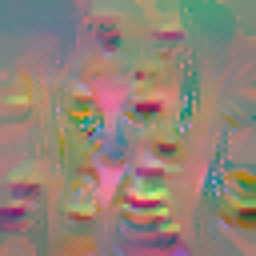

In [6]:

run_name = "test"
shutil.rmtree(run_name, ignore_errors=True)
os.makedirs(run_name)
dr = DeepResp(deepdream_model, calc_loss_one_out, 2500, 0.01)
for i in range(5):
    random_image = tf.random.uniform(
        [64, 64, 3],
        minval=0,
        maxval=None,
        dtype=tf.dtypes.float32,
        seed=None,
        name=None,
    )
    image = dr(random_image)
    image_to_save = cv2.cvtColor(image.numpy(), cv2.COLOR_RGB2BGR)
    image_to_save = cv2.resize(image_to_save, (256, 256))
    cv2.imwrite(f"{run_name}/{i}.jpg", image_to_save)